In [7]:
!pip install scikit-image
!pip install opencv-python
!pip install torch torchvision
!pip install seaborn


   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------  12.6/12.8 MB 60.4 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 47.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 31.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/113.7 MB ? eta -:--:--
   ---------------------------------------- 0.5/113.7 MB 4.2 MB/s eta 0:00:27
    --------------------------------------- 1.6/113.7 MB 5.2 MB/s eta 0:00:22
   - -------------------------------------- 3.1/113.7 MB 6.0 MB/s eta 0:00:19
   - -------------------------------------- 4.2/113.7 MB 6.3 MB/s eta 0:00:18
   -- ------------------------------------- 5.8/113.7 MB 6.2 MB/s eta 0:00:18
   -- ------------------------------------- 7.1/113.7 MB 6.3 MB/s eta 0:00:17
   -- ------------------------------------- 8.4/113.7 MB 6.3 MB/s eta 0:00:17
   --- --

In [1]:
# ===============================
# CELL 1 — Imports
# ===============================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Image processing
import cv2
from skimage.feature import graycomatrix, graycoprops

# Deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [13]:
# ===============================
# CELL 2 — Dataset Path (FINAL)
# ===============================

DATASET_PATH = "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\dataset"

class_mapping = {
    "Tumor": 1,   # malignant
    "Cyst": 0,
    "Stone": 0,
    "Normal": 0
}

image_paths = []
labels = []

print("Folders found:", os.listdir(DATASET_PATH))  # debug check

for folder in os.listdir(DATASET_PATH):

    folder_path = os.path.join(DATASET_PATH, folder)

    if folder not in class_mapping:
        continue

    for img in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img))
        labels.append(class_mapping[folder])

print("Total images:", len(image_paths))


Folders found: ['Cyst', 'Normal', 'Stone', 'Tumor']
Total images: 12446


In [ ]:
##Image Preprocessing##(step2)

import cv2

IMG_SIZE = 224

def preprocess_image(path):

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    # noise reduction
    img = cv2.GaussianBlur(img, (3,3), 0)

    # normalization
    img = img / 255.0

    return img


In [ ]:
##Augumentation##(step3)

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(contrast=0.2),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])


In [18]:
##step 4:Feature Extraction(GLCM)

from skimage.feature import graycomatrix, graycoprops

def extract_features(path):

    img = preprocess_image(path)
    img_uint8 = (img * 255).astype(np.uint8)

    glcm = graycomatrix(
        img_uint8,
        distances=[1],
        angles=[0],
        symmetric=True,
        normed=True
    )

    features = [
        graycoprops(glcm, 'contrast')[0,0],
        graycoprops(glcm, 'correlation')[0,0],
        graycoprops(glcm, 'energy')[0,0],
        graycoprops(glcm, 'homogeneity')[0,0],
        np.mean(img),
        np.std(img)
    ]

    return features


In [19]:
##step 5: Feature Vector creation

X_features = np.array([extract_features(p) for p in image_paths])
y_labels = np.array(labels)

print("Feature shape:", X_features.shape)


Feature shape: (12446, 6)


In [22]:
##TRAIN CLASSICAL ML MODELS(STEP 6)

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_labels,
    test_size=0.2,
    stratify=y_labels,
    random_state=42
)

models_ml = {
    "SVM": SVC(kernel="rbf", class_weight="balanced"),
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced"
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    )
}


results_ml = {}

for name, model in models_ml.items():
    model.fit(X_train, y_train)
    results_ml[name] = model.predict(X_test)



 SVM
              precision    recall  f1-score   support

           0       0.81      0.56      0.66      2033
           1       0.18      0.44      0.26       457

    accuracy                           0.54      2490
   macro avg       0.50      0.50      0.46      2490
weighted avg       0.70      0.54      0.59      2490



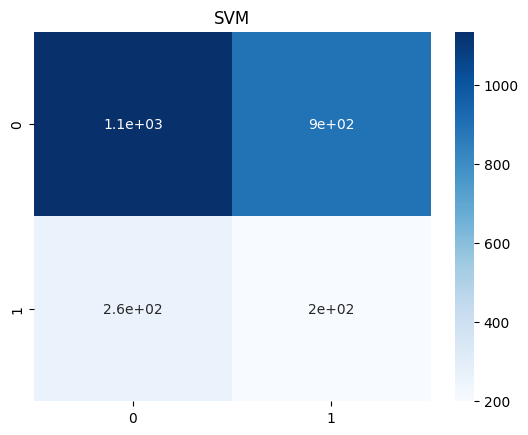


 RandomForest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2033
           1       1.00      0.95      0.97       457

    accuracy                           0.99      2490
   macro avg       0.99      0.97      0.98      2490
weighted avg       0.99      0.99      0.99      2490



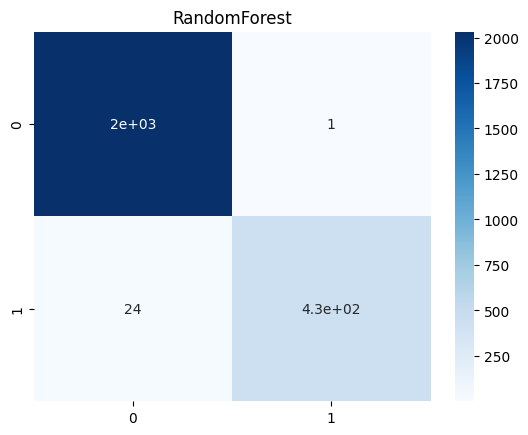


 LogisticRegression
              precision    recall  f1-score   support

           0       0.90      0.66      0.76      2033
           1       0.31      0.68      0.43       457

    accuracy                           0.66      2490
   macro avg       0.61      0.67      0.60      2490
weighted avg       0.79      0.66      0.70      2490



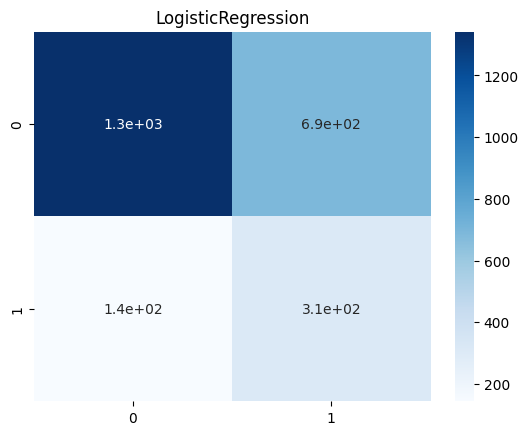

In [ ]:
##MODEL EVALUATION(step 7)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for name, preds in results_ml.items():

    print("\n", name)
    print(classification_report(y_test, preds))

    cm = confusion_matrix(y_test, preds)

    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title(name)
    plt.show()


In [ ]:
##comparision of ml models

import pandas as pd
from sklearn.metrics import accuracy_score

comparison = []

for name, preds in results_ml.items():
    comparison.append([
        name,
        accuracy_score(y_test, preds)
    ])

df = pd.DataFrame(comparison, columns=["Model", "Accuracy"])
df


,Model,Accuracy
0,SVM,0.536145
1,RandomForest,0.989960
2,LogisticRegression,0.664659


In [ ]:
##DEEP LEARNING(transfer learning)step-8

from torch.utils.data import Dataset
from PIL import Image
import torch

class KidneyDataset(Dataset):

    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        img = Image.open(self.paths[idx]).convert("L")

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).float()
        return img, label


In [29]:
# ===============================
# FIX — Separate split for DL
# ===============================

from sklearn.model_selection import train_test_split
import numpy as np

image_paths = np.array(image_paths)
labels = np.array(labels)

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print("Train images:", len(X_train_dl))
print("Test images:", len(X_test_dl))


Train images: 9956
Test images: 2490


In [30]:
train_dataset = KidneyDataset(
    X_train_dl,
    y_train_dl,
    train_transform
)

test_dataset = KidneyDataset(
    X_test_dl,
    y_test_dl,
    val_test_transform
)


from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [31]:
##load ResNet
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="DEFAULT")

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

model = model.to(device)


In [33]:
##training
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

EPOCHS = 10

for epoch in range(EPOCHS):

    model.train()
    running_loss = 0

    for imgs, labels in train_loader:

        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Loss:", running_loss)


Epoch 1 Loss: 81.22117621451616
Epoch 2 Loss: 77.50031551718712
Epoch 3 Loss: 73.50207802653313
Epoch 4 Loss: 72.13481309264898
Epoch 5 Loss: 72.43274968117476
Epoch 6 Loss: 72.32887338101864
Epoch 7 Loss: 69.02914745360613
Epoch 8 Loss: 72.27389696985483
Epoch 9 Loss: 70.26707939058542
Epoch 10 Loss: 69.60682681202888


In [34]:
##evaluation

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model.eval()   # VERY IMPORTANT (turns off training behaviour)

dl_preds = []
dl_true = []

with torch.no_grad():   # no gradient calculation → faster

    for imgs, labels in test_loader:

        imgs = imgs.to(device)

        outputs = model(imgs).squeeze()

        preds = (outputs > 0.5).cpu().numpy()

        dl_preds.extend(preds)
        dl_true.extend(labels.numpy())

print(classification_report(dl_true, dl_preds))

dl_accuracy = accuracy_score(dl_true, dl_preds)
print("Deep Learning Accuracy:", dl_accuracy)


              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      2033
         1.0       0.95      0.67      0.78       457

    accuracy                           0.93      2490
   macro avg       0.94      0.83      0.87      2490
weighted avg       0.93      0.93      0.93      2490

Deep Learning Accuracy: 0.9317269076305221


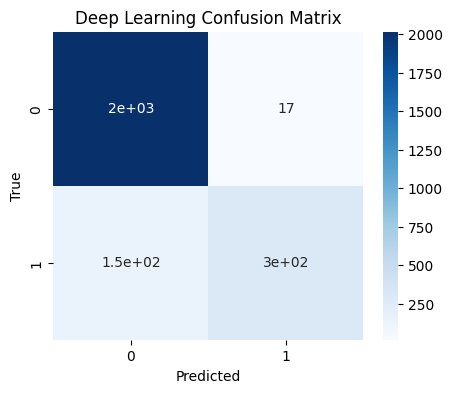

In [35]:
cm = confusion_matrix(dl_true, dl_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Deep Learning Confusion Matrix")
plt.show()


In [ ]:
#comparision with classical ML(step-9)
import pandas as pd

comparison = []

# Classical ML results
for name, preds in results_ml.items():
    acc = accuracy_score(y_test, preds)
    comparison.append([name, acc])

# Deep learning result
comparison.append(["ResNet18 (Deep Learning)", dl_accuracy])

df_compare = pd.DataFrame(comparison, columns=["Model", "Accuracy"])

df_compare


,Model,Accuracy
0,SVM,0.536145
1,RandomForest,0.989960
2,LogisticRegression,0.664659
3,ResNet18 (Deep Learning),0.931727


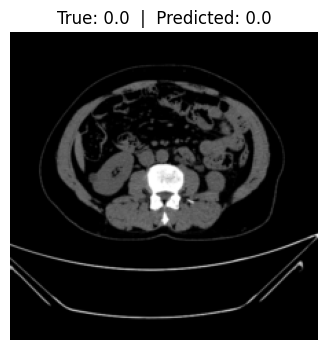

In [37]:
#Apply Grad-CAM 

def show_prediction(dataset, idx=0):
    
    model.eval()

    img, label = dataset[idx]

    input_img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        pred = (output > 0.5).float().item()

    plt.figure(figsize=(4,4))
    plt.imshow(img.permute(1,2,0), cmap="gray")
    plt.title(f"True: {label}  |  Predicted: {pred}")
    plt.axis("off")
    plt.show()

# show one example
show_prediction(test_dataset, 0)


In [ ]:
#save-best model
torch.save(model.state_dict(), "dl_resnet_model.pth")

print("Model saved successfully!")


Model saved successfully!


In [39]:
import joblib

# suppose rf is your trained RandomForest model
joblib.dump(models_ml["RandomForest"], "best_random_forest.pkl")

print("Random Forest model saved!")


Random Forest model saved!
